# **Projet TAL - RI**

# Partie 1 - Préparation

Le jeu de données sur lequel nous allons travailler comporte des tours de parole des députés dans les débats de l'Assemblée nationale en France. Ces tours de paroles sont fourni avec une date et le parti politique des députés ayant pris la parole.

L'objectif est de notre projet prédire si le tour de parole est celui d'un député de gauche ou de droite.

Dans un premier temps, nous allons télécharger les fichiers nécessaires.

In [1]:
!gdown --id 1e2cYeC81ckV7a7dZaJHthoDwvwhIlZLV


Downloading...
From: https://drive.google.com/uc?id=1e2cYeC81ckV7a7dZaJHthoDwvwhIlZLV
To: /content/debats.csv
52.5MB [00:00, 166MB/s]


Importations des bibliothéques

In [2]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn import metrics
import nltk
import codecs
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from spacy.lang.fr import French
from nltk.stem.snowball import SnowballStemmer
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn import svm
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
debats = pd.read_csv("debats.csv", sep=",", dtype={'dateSeance': 'object','texte': 'object','groupe_politique': 'category'})
# Nettoyage des données : on retire les doublons et des NaN
debats = debats.drop_duplicates().dropna()

In [4]:
debats.head()

,Unnamed: 0,dateSeance,texte,groupe_politique
0,0,20190115150000000,"Prochaine séance, ce soir, à vingt et une heur...",LaREM
4,4,20190115150000000,"Dans cet esprit, pourquoi avoir refusé un chan...",SOC
5,5,20190115150000000,Et l’immigration ?,NI
6,6,20190115150000000,"Le pompier qui est dans le coma, ce n’est pas ...",FI
7,7,20190115150000000,Vous en savez quelque chose !,SOC


Pour obtenir un nombre satisfaisant d’exemples par groupe politique, on considérera uniquement deux groupes : "droite" et "gauche". Nous considérerons que le parti LR fait partie de la classe "droite", et que les partis SOC, GDR et FI font partie de la classe "gauche". Les autres groupe politique seront ignorés.

Ainsi nous avons donc stocké d'une part le discours (texte),  et d'une autre part les orientations (gauche/droite) associées à ces discours.

In [5]:
df = pd.DataFrame([],columns=['texte','orientation_politique'])
for a in debats.itertuples():
  if ((a.groupe_politique == 'SOC' or a.groupe_politique == 'GDR' or a.groupe_politique == 'FI') and len(str(a.texte).split())>20):
    df = df.append({'texte':a.texte,'orientation_politique':'gauche'},ignore_index=True)
  if (a.groupe_politique == 'LR' and len(str(a.texte).split())>20):
    df = df.append({'texte':a.texte,'orientation_politique':'droite'},ignore_index=True)

In [6]:
df.head()

,texte,orientation_politique
0,"Dans cet esprit, pourquoi avoir refusé un chan...",gauche
1,"Le pompier qui est dans le coma, ce n’est pas ...",gauche
2,Le groupe La France insoumise ne désespère pas...,gauche
3,Le groupe de la Gauche démocrate et républicai...,gauche
4,"Est-ce donc cela, votre vision de l’impartiali...",droite


In [7]:
df.orientation_politique.value_counts()

gauche    6102
droite    5407
Name: orientation_politique, dtype: int64

# Partie 2 - Pré traitement et vectorisations des données

In [8]:
X = df['texte']
y = df.orientation_politique
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=12, shuffle=True)

Nous allons commencer par découper les textes en mots et supprimer les "stop-words".

In [9]:
# configuration of stopwords
stopWords = set(stopwords.words('french'))

#Tokenizer
tokenizer = nltk.RegexpTokenizer(r'\w+')

def return_token(sentence):
    return tokenizer.tokenize(sentence)


# Stemming : load french dictionary
stemmer = SnowballStemmer(language='french')

vectorizer = TfidfVectorizer(tokenizer= return_token,lowercase=True, stop_words=stopWords)
vectors = vectorizer.fit_transform(X)

# Partie 3 - Implémentation de différent modèle de prédictions



Model Naive de Bayes

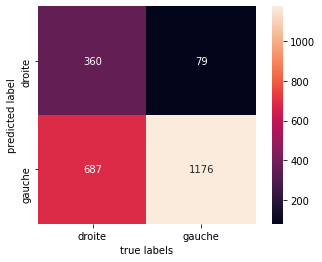

The accuracy with Bayes is 66.72458731537793 %


In [10]:
# Build the Bayes model --------------------------------------------------------------------------------------------------------------
model = make_pipeline(vectorizer, MultinomialNB())  # Train the model using the training data
model.fit(X_train, y_train)  # Predict the categories of the test data
predicted_categories = model.predict(X_test)


# plot the confusion matrix of Bayes
mat = confusion_matrix(predicted_categories, y_test)
sns.heatmap(mat, square = True, annot=True, fmt = "d", xticklabels = ["droite", "gauche"], yticklabels =  ["droite", "gauche"])
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()

print("The accuracy with Bayes is {} %".format(accuracy_score(y_test, predicted_categories)*100))

In [11]:
print(metrics.classification_report(y_test,predicted_categories))

              precision    recall  f1-score   support

      droite       0.82      0.34      0.48      1047
      gauche       0.63      0.94      0.75      1255

    accuracy                           0.67      2302
   macro avg       0.73      0.64      0.62      2302
weighted avg       0.72      0.67      0.63      2302



Model avec SVM

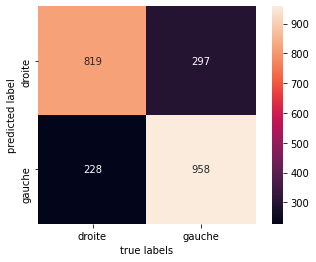

The accuracy with SVM is 77.19374456993918 %


In [12]:
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
model_SVM = make_pipeline(vectorizer, SVM)  # Train the model using the training data
model_SVM.fit(X_train,y_train)
# predict the labels on validation dataset
predictions_SVM = model_SVM.predict(X_test)

mat_b = confusion_matrix(predictions_SVM , y_test)
sns.heatmap(mat_b, square = True, annot=True, fmt = "d", xticklabels = ["droite", "gauche"], yticklabels =  ["droite", "gauche"])
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()

print("The accuracy with SVM is {} %".format(accuracy_score(y_test,predictions_SVM)*100))

In [13]:
print(metrics.classification_report(y_test,predictions_SVM))

              precision    recall  f1-score   support

      droite       0.73      0.78      0.76      1047
      gauche       0.81      0.76      0.78      1255

    accuracy                           0.77      2302
   macro avg       0.77      0.77      0.77      2302
weighted avg       0.77      0.77      0.77      2302



Model Avec Randomtreeforest

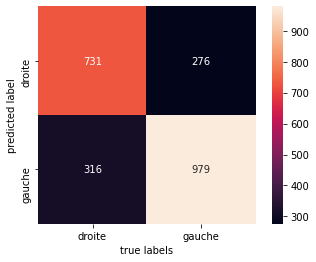

The accuracy with RTF is 0.7428323197219809 %


In [14]:
# Build Random Tree Forest model -----------------------------------------------------------------------------------------------------
rf = RandomForestClassifier()
model_RF = make_pipeline(vectorizer, rf)
model_RF.fit(X_train, y_train)
predictions_rf = model_RF.predict(X_test)

# plot the confusion matrix of Random Tree Forest
mat_r = confusion_matrix(predictions_rf, y_test)
sns.heatmap(mat_r, square = True, annot=True, fmt = "d", xticklabels =  ["droite", "gauche"], yticklabels =  ["droite", "gauche"])
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()
print("The accuracy with RTF is {} %".format(accuracy_score(y_test,predictions_rf)))

In [15]:
print(metrics.classification_report(y_test,predictions_rf))

              precision    recall  f1-score   support

      droite       0.73      0.70      0.71      1047
      gauche       0.76      0.78      0.77      1255

    accuracy                           0.74      2302
   macro avg       0.74      0.74      0.74      2302
weighted avg       0.74      0.74      0.74      2302



#Partie 4 - Analyse des résultats

Nous avons utilisés 3 algorithme afin de classifier notre jeu de données :
- MultinomialNB
- SVM
- RandomForestClassifier

Parmi c'est 3 différent algorithme c'est celui avec SVM qui fonctionne le mieux. En Effet avec avec cet algorithme on obtient une précision de 77%. C'est une précision assez satisfaisante pour ce genre de données. Ce qui réduit peut-être la précisions de nos algorithmes est le fait que certains députés de LaRem ont un discours plus centristes que de droites.